# Lab 07 - Regresja

## Zadanie

Wykorzystując zbiór danych [UTKFace](https://susanqq.github.io/UTKFace/) przygotuj potok uczący model estymujący wiek, płec i rasę osób na zdjęciach.

In [1]:
!pip install lightning torchmetrics timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!wget https://chmura.put.poznan.pl/s/G45dtgR4jOPELLO/download
!unzip download

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: UTKFace/53_0_1_20170116191725055.jpg.chip.jpg  
  inflating: UTKFace/53_0_1_20170116192938845.jpg.chip.jpg  
  inflating: UTKFace/53_0_1_20170117181950281.jpg.chip.jpg  
  inflating: UTKFace/53_0_1_20170120222553113.jpg.chip.jpg  
  inflating: UTKFace/53_0_1_20170120222956787.jpg.chip.jpg  
  inflating: UTKFace/53_0_1_20170120223004304.jpg.chip.jpg  
  inflating: UTKFace/53_0_2_20170104210010763.jpg.chip.jpg  
  inflating: UTKFace/53_0_2_20170112215433623.jpg.chip.jpg  
  inflating: UTKFace/53_0_2_20170112221930338.jpg.chip.jpg  
  inflating: UTKFace/53_0_2_20170116192925824.jpg.chip.jpg  
  inflating: UTKFace/53_0_2_20170116192934154.jpg.chip.jpg  
  inflating: UTKFace/53_0_2_20170119205816456.jpg.chip.jpg  
  inflating: UTKFace/53_0_3_20170104220848558.jpg.chip.jpg  
  inflating: UTKFace/53_0_3_20170109132854337.jpg.chip.jpg  
  inflating: UTKFace/53_0_3_20170109142546975.jpg.chip.jpg  
  inflating: UTKFace

In [3]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory
from sklearn.model_selection import train_test_split
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Wczytanie danych

In [4]:
folder_path = "/content/UTKFace"
image_paths = [os.path.join(folder_path, fname) for fname in os.listdir(folder_path) if fname.endswith(('.jpg', '.png'))]
df = pd.DataFrame(image_paths, columns=["image_path"])
pd.set_option('display.max_colwidth', None)
print(df.head())
print(df.shape)

                                               image_path
0  /content/UTKFace/31_1_1_20170116170019856.jpg.chip.jpg
1  /content/UTKFace/24_1_2_20170116171034407.jpg.chip.jpg
2  /content/UTKFace/29_0_3_20170104220737116.jpg.chip.jpg
3  /content/UTKFace/35_0_0_20170117183000621.jpg.chip.jpg
4  /content/UTKFace/26_0_3_20170117153930604.jpg.chip.jpg
(23708, 1)


Dodanie targetów

In [5]:
df[["age", "gender", "race"]] = df["image_path"].str.extract(r'/(\d+)_(\d+)_(\d+)_')
df = df.dropna(subset=["age", "gender", "race"])
df[["gender", "race"]] = df[["gender", "race"]].astype(int)
df["age"] = df["age"].astype(float)

df["age"] = df["age"] / df["age"].abs().max()

print(df.head())
print(df.shape)


                                               image_path       age  gender  \
0  /content/UTKFace/31_1_1_20170116170019856.jpg.chip.jpg  0.267241       1   
1  /content/UTKFace/24_1_2_20170116171034407.jpg.chip.jpg  0.206897       1   
2  /content/UTKFace/29_0_3_20170104220737116.jpg.chip.jpg  0.250000       0   
3  /content/UTKFace/35_0_0_20170117183000621.jpg.chip.jpg  0.301724       0   
4  /content/UTKFace/26_0_3_20170117153930604.jpg.chip.jpg  0.224138       0   

   race  
0     1  
1     2  
2     3  
3     0  
4     3  
(23705, 4)


In [6]:
gender_map = {0: "Male", 1: "Female"}
race_map = {
    0: "White",
    1: "Black",
    2: "Asian",
    3: "Indian",
    4: "Other"
}

In [7]:
org_df = df.copy()

Dzielenie danych

In [8]:
X = np.array(df.drop(columns=['age', 'gender', 'race']))
y = np.array(df[['age', 'gender', 'race']])
print(X[:5])
print(y[:5])

[['/content/UTKFace/31_1_1_20170116170019856.jpg.chip.jpg']
 ['/content/UTKFace/24_1_2_20170116171034407.jpg.chip.jpg']
 ['/content/UTKFace/29_0_3_20170104220737116.jpg.chip.jpg']
 ['/content/UTKFace/35_0_0_20170117183000621.jpg.chip.jpg']
 ['/content/UTKFace/26_0_3_20170117153930604.jpg.chip.jpg']]
[[0.26724138 1.         1.        ]
 [0.20689655 1.         2.        ]
 [0.25       0.         3.        ]
 [0.30172414 0.         0.        ]
 [0.22413793 0.         3.        ]]


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5)

print(X_train.shape, X_val.shape, X_test.shape)

(16593, 1) (3556, 1) (3556, 1)


In [46]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    #transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    # transforms.RandomRotation(10),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225]),
    transforms.ConvertImageDtype(torch.float)
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225]),
])

DATASET

In [47]:
class MYDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X  # ścieżki jako numpy array lub lista
        self.y = y  # numpy array: kolumny [age, gender, race]
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image_path = self.X[idx]

        if isinstance(image_path, np.ndarray):
          image_path = image_path.item()

        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
            image = image.to(device)


        age = torch.tensor(self.y[idx][0], dtype=torch.float).to(device)
        gender = torch.tensor(self.y[idx][1], dtype=torch.long).to(device)
        race = torch.tensor(self.y[idx][2], dtype=torch.long).to(device)

        return image, age, gender, race



In [48]:
train_dataset = MYDataset(X=X_train, y=y_train, transform=transform)
val_dataset = MYDataset(X=X_val, y=y_val, transform=val_transform)
test_dataset = MYDataset(X=X_test, y=y_test, transform=val_transform)

In [49]:
train_dataset.__getitem__(78)

(tensor([[[0.2667, 0.2627, 0.2706,  ..., 0.8000, 0.8000, 0.8000],
          [0.2667, 0.2667, 0.2824,  ..., 0.8000, 0.8000, 0.8000],
          [0.2627, 0.2627, 0.2784,  ..., 0.8000, 0.8000, 0.8000],
          ...,
          [0.0980, 0.0706, 0.0471,  ..., 0.7725, 0.5333, 0.0000],
          [0.1020, 0.0784, 0.0627,  ..., 0.7608, 0.3922, 0.0000],
          [0.1255, 0.1137, 0.1098,  ..., 0.7333, 0.0784, 0.0000]],
 
         [[0.3255, 0.3137, 0.3137,  ..., 0.8000, 0.8000, 0.8000],
          [0.3216, 0.3137, 0.3255,  ..., 0.8000, 0.8000, 0.8000],
          [0.3020, 0.3059, 0.3137,  ..., 0.8000, 0.8000, 0.8000],
          ...,
          [0.1098, 0.0784, 0.0471,  ..., 0.7725, 0.5333, 0.0000],
          [0.1255, 0.0980, 0.0784,  ..., 0.7608, 0.3922, 0.0000],
          [0.1529, 0.1412, 0.1255,  ..., 0.7333, 0.0784, 0.0000]],
 
         [[0.3922, 0.3882, 0.3922,  ..., 0.8000, 0.8000, 0.8000],
          [0.3922, 0.3922, 0.3961,  ..., 0.8000, 0.8000, 0.8000],
          [0.3765, 0.3765, 0.3922,  ...,

In [50]:
LR = 1e-4
BATCH_SIZE = 32
EPOCHS = 8

In [51]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [52]:
import timm
import torch.nn as nn

class MultiModel(nn.Module):
  def __init__(self, backbone_name='resnet50'):
        super().__init__()
        self.backbone = timm.create_model(backbone_name, pretrained=True, num_classes=0)
        in_features = self.backbone.num_features # liczba cech z ostatniej warstwy

        self.age_lin = nn.Linear(in_features, 1)
        self.gender_lin = nn.Linear(in_features, 2)
        self.race_lin = nn.Linear(in_features, 5)

  def forward(self, x):
    root = self.backbone(x)
    age = self.age_lin(root).squeeze(1)         # (B)
    gender = self.gender_lin(root)              # (B, 2)
    race = self.race_lin(root)                  # (B, num_races)
    return age, gender, race


Tworzenie Modelu

In [53]:
model = MultiModel().to(device)

In [54]:
criterion_gender = nn.CrossEntropyLoss()
criterion_race = nn.CrossEntropyLoss()
criterion_age = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=LR)

In [55]:
total_loss_train_plot = []
total_loss_val_plot = []
acc_age_plot = []
acc_gender_plot = []
acc_race_plot = []

acc_age_plot_val = []
acc_gender_plot_val = []
acc_race_plot_val = []

for epoch in range(EPOCHS):
    total_loss_train = 0
    total_mae_age = 0
    total_acc_gender = 0
    total_acc_race = 0

    model.train()
    for data in train_loader:
        optimizer.zero_grad()

        image, age, gender, race = data

        outputs = model(image)
        pred_age, pred_gender, pred_race = outputs

        loss_age = criterion_age(pred_age, age)
        loss_gender = criterion_gender(pred_gender, gender)
        loss_race = criterion_race(pred_race, race)

        loss = loss_age * 0.8 + loss_gender * 0.5 + loss_race
        total_loss_train += loss.item()
        loss.backward()
        optimizer.step()

        pred_gender_labels = torch.argmax(pred_gender, dim=1)
        pred_race_labels = torch.argmax(pred_race, dim=1)

        acc_gender = (pred_gender_labels == gender).float().mean().item()
        acc_race = (pred_race_labels == race).float().mean().item()
        mae_age = torch.abs(pred_age - age).mean().item()

        total_acc_gender += acc_gender
        total_acc_race += acc_race
        total_mae_age += mae_age

    avg_loss_train = total_loss_train / len(train_loader)
    avg_acc_gender = total_acc_gender / len(train_loader)
    avg_acc_race = total_acc_race / len(train_loader)
    avg_mae_age = total_mae_age / len(train_loader)

    model.eval()
    with torch.no_grad():
        total_loss_val = 0
        total_mae_age_val = 0
        total_acc_gender_val = 0
        total_acc_race_val = 0

        for val_data in val_loader:
            image, age, gender, race = val_data

            outputs = model(image)
            pred_age, pred_gender, pred_race = outputs

            loss_age = criterion_age(pred_age, age)
            loss_gender = criterion_gender(pred_gender, gender)
            loss_race = criterion_race(pred_race, race)

            loss = loss_age * 0.8 + loss_gender * 0.5 + loss_race
            total_loss_val += loss.item()

            pred_gender_labels = torch.argmax(pred_gender, dim=1)
            pred_race_labels = torch.argmax(pred_race, dim=1)

            acc_gender = (pred_gender_labels == gender).float().mean().item()
            acc_race = (pred_race_labels == race).float().mean().item()
            mae_age = torch.abs(pred_age - age).mean().item()

            total_acc_gender_val += acc_gender
            total_acc_race_val += acc_race
            total_mae_age_val += mae_age

        avg_loss_val = total_loss_val / len(val_loader)
        avg_acc_gender_val = total_acc_gender_val / len(val_loader)
        avg_acc_race_val = total_acc_race_val / len(val_loader)
        avg_mae_age_val = total_mae_age_val / len(val_loader)

    total_loss_train_plot.append(avg_loss_train)
    total_loss_val_plot.append(avg_loss_val)
    acc_age_plot.append(avg_mae_age)
    acc_gender_plot.append(avg_acc_gender)
    acc_race_plot.append(avg_acc_race)
    acc_age_plot_val.append(avg_mae_age_val)
    acc_gender_plot_val.append(avg_acc_gender_val)
    acc_race_plot_val.append(avg_acc_race_val)

    print(f'''Epoch {epoch + 1}/{EPOCHS}
    Train -> Loss: {avg_loss_train:.4f}, Age MAE: {avg_mae_age:.4f}, Gender Acc: {avg_acc_gender:.4f}, Race Acc: {avg_acc_race:.4f}
    Val   -> Loss: {avg_loss_val:.4f}, Age MAE: {avg_mae_age_val:.4f}, Gender Acc: {avg_acc_gender_val:.4f}, Race Acc: {avg_acc_race_val:.4f}''')
    print("=" * 40)


Epoch 1/8
    Train -> Loss: 1.5691, Age MAE: 0.1178, Gender Acc: 0.7165, Race Acc: 0.4916
    Val   -> Loss: 1.2470, Age MAE: 0.0998, Gender Acc: 0.8119, Race Acc: 0.6161
Epoch 2/8
    Train -> Loss: 1.0845, Age MAE: 0.0989, Gender Acc: 0.8249, Race Acc: 0.6804
    Val   -> Loss: 0.9471, Age MAE: 0.0938, Gender Acc: 0.8622, Race Acc: 0.7218
Epoch 3/8
    Train -> Loss: 0.8348, Age MAE: 0.0909, Gender Acc: 0.8697, Race Acc: 0.7615
    Val   -> Loss: 0.8188, Age MAE: 0.0917, Gender Acc: 0.8806, Race Acc: 0.7679
Epoch 4/8
    Train -> Loss: 0.6924, Age MAE: 0.0867, Gender Acc: 0.8884, Race Acc: 0.8051
    Val   -> Loss: 0.7701, Age MAE: 0.0844, Gender Acc: 0.8901, Race Acc: 0.7941
Epoch 5/8
    Train -> Loss: 0.5774, Age MAE: 0.0828, Gender Acc: 0.9061, Race Acc: 0.8378
    Val   -> Loss: 0.7491, Age MAE: 0.0818, Gender Acc: 0.8940, Race Acc: 0.7966
Epoch 6/8
    Train -> Loss: 0.4626, Age MAE: 0.0808, Gender Acc: 0.9193, Race Acc: 0.8745
    Val   -> Loss: 0.7469, Age MAE: 0.0789, Gende

In [39]:
model.eval()
with torch.no_grad():
    total_loss_test = 0
    total_mae_age_test = 0
    total_acc_gender_test = 0
    total_acc_race_test = 0

    for test_data in test_loader:
        image, age, gender, race = test_data

        outputs = model(image)
        pred_age, pred_gender, pred_race = outputs

        loss_age = criterion_age(pred_age, age)
        loss_gender = criterion_gender(pred_gender, gender)
        loss_race = criterion_race(pred_race, race)

        loss = loss_age + loss_gender + loss_race
        total_loss_test += loss.item()

        pred_gender_labels = torch.argmax(pred_gender, dim=1)
        pred_race_labels = torch.argmax(pred_race, dim=1)

        acc_gender = (pred_gender_labels == gender).float().mean().item()
        acc_race = (pred_race_labels == race).float().mean().item()
        mae_age = torch.abs(pred_age - age).mean().item()

        total_acc_gender_test += acc_gender
        total_acc_race_test += acc_race
        total_mae_age_test += mae_age

    avg_loss_test = total_loss_test / len(test_loader)
    avg_acc_gender_test = total_acc_gender_test / len(test_loader)
    avg_acc_race_test = total_acc_race_test / len(test_loader)
    avg_mae_age_test = total_mae_age_test / len(test_loader)

print(f'''Test results:
Loss: {avg_loss_test:.4f}, Age MAE: {avg_mae_age_test:.4f}, Gender Acc: {avg_acc_gender_test:.4f}, Race Acc: {avg_acc_race_test:.4f}''')
print("=" * 40)



Test results:
Loss: 0.9661, Age MAE: 0.0788, Gender Acc: 0.9079, Race Acc: 0.8036


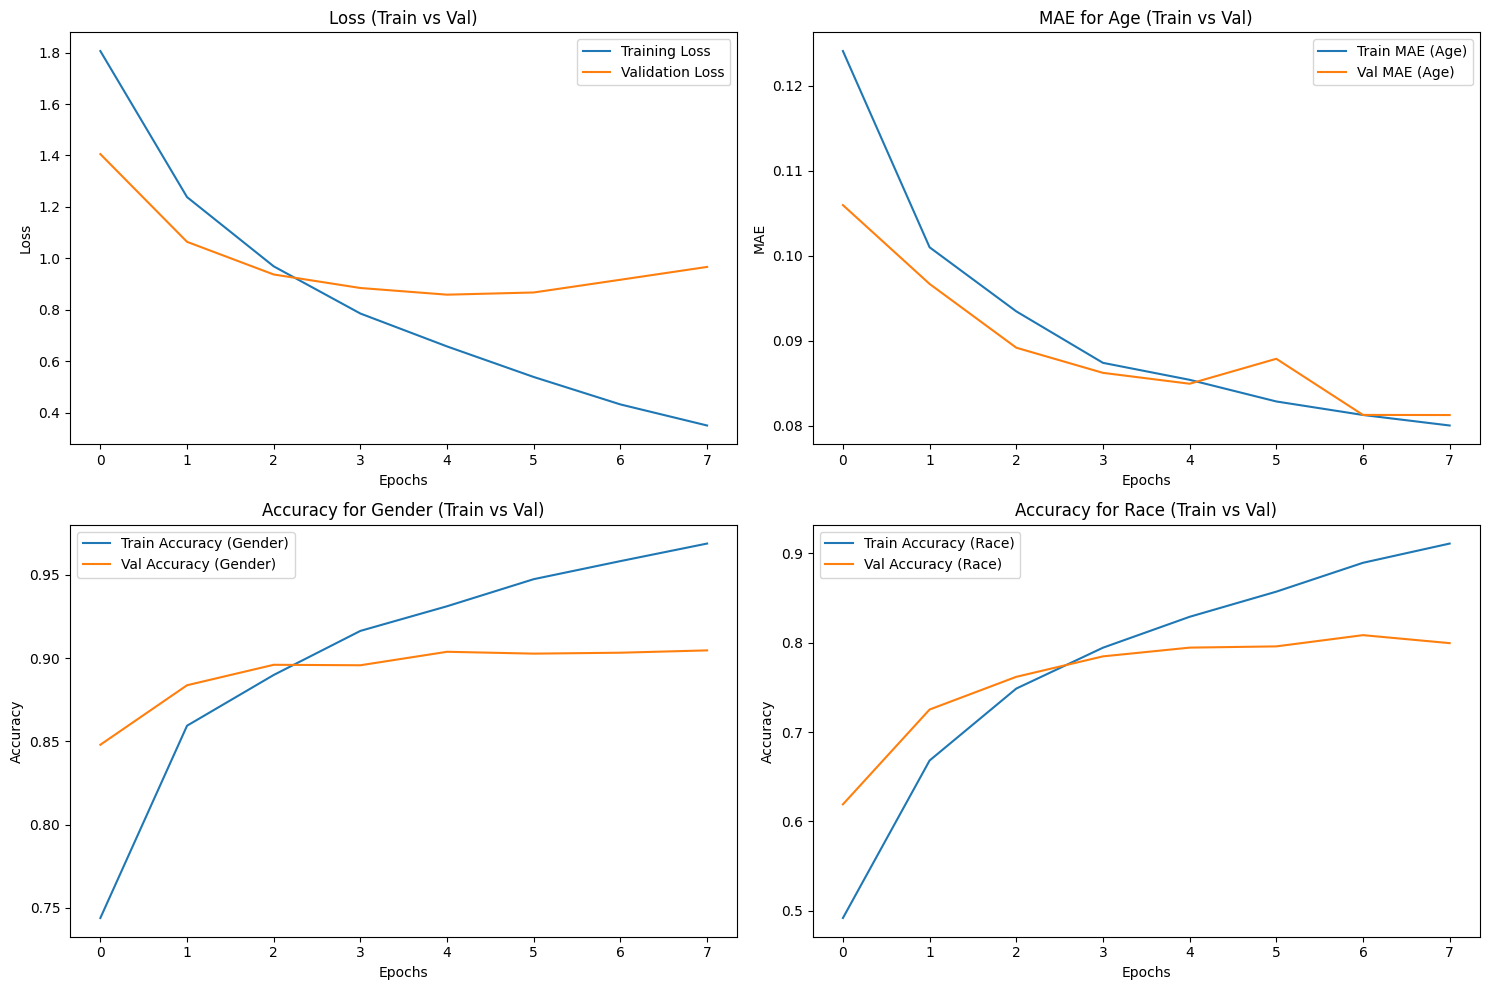

In [40]:

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Wykres strat
axs[0, 0].plot(total_loss_train_plot, label='Training Loss')
axs[0, 0].plot(total_loss_val_plot, label='Validation Loss')
axs[0, 0].set_title('Loss (Train vs Val)')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()

# Wykres MAE wieku
axs[0, 1].plot(acc_age_plot, label='Train MAE (Age)')
axs[0, 1].plot(acc_age_plot_val, label='Val MAE (Age)')
axs[0, 1].set_title('MAE for Age (Train vs Val)')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('MAE')
axs[0, 1].legend()

# Wykres dokładności płci
axs[1, 0].plot(acc_gender_plot, label='Train Accuracy (Gender)')
axs[1, 0].plot(acc_gender_plot_val, label='Val Accuracy (Gender)')
axs[1, 0].set_title('Accuracy for Gender (Train vs Val)')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].legend()

# Wykres dokładności rasy
axs[1, 1].plot(acc_race_plot, label='Train Accuracy (Race)')
axs[1, 1].plot(acc_race_plot_val, label='Val Accuracy (Race)')
axs[1, 1].set_title('Accuracy for Race (Train vs Val)')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

In [41]:
def pred_image(img_path):
  image = Image.open(img_path).convert("RGB")
  plt.imshow(image)
  plt.show()
  image = transform(image).to(device)
  #print(image.shape)
  output = model(image.unsqueeze(0))
  pred_age, pred_gender, pred_race = output
  pred_gender_labels = torch.argmax(pred_gender, dim=1)
  pred_race_labels = torch.argmax(pred_race, dim=1)

  return pred_age.item()*105, gender_map[pred_gender_labels.item()], race_map[pred_race_labels.item()]

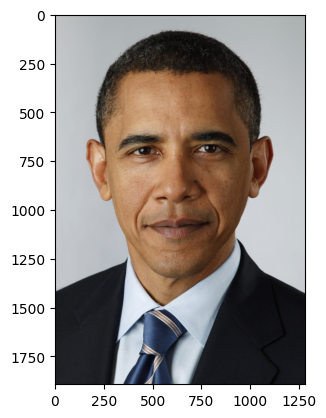

(48.64448681473732, 'Male', 'Black')

In [42]:

pred_image('/content/Official_portrait_of_Barack_Obama-2.jpg')

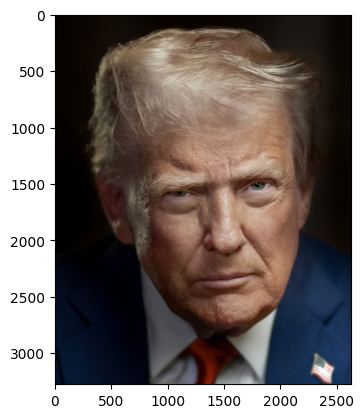

(75.95012158155441, 'Male', 'Asian')

In [62]:
pred_image('/content/Official_Presidential_Portrait_of_President_Donald_J._Trump_(2025)_(cropped).jpg')

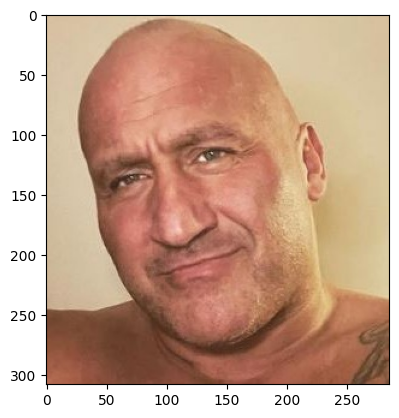

(41.23885586857796, 'Male', 'Black')

In [74]:
pred_image('/content/Przechwytywanie-7.jpg')

Model najlepiej radzi sobie z płcią, torszeczkę gorzej z wiekiem a najgorzej z rasą człowieka.

Model przy dużej ilości epok zaczyna szybko się przyuczać, nie pomagają transformację, może dropout by coś zmienił. Prawdopodobnie dane na których korzystam są dość podobne i jednoznaczne. Dodatkowo mamy tu do czynienia z Multitaskiem dla sztucznej przez co nie można jednoznacznie trafić we wszystkie cechy.